## Importing Packages ##

In [2]:
import os
import sys
import subprocess
import tempfile
import random
import glob
from itertools import compress
import os.path as op
import numpy as np
import skimage.io as sio
import pandas as pd
import importlib
import math
from math import sqrt
import matplotlib.pyplot as plt
from os import listdir, getcwd, chdir
from os.path import isfile, join
from sklearn import linear_model
from sklearn import svm

import diff_classifier
import diff_classifier.utils as ut
import diff_classifier.msd as msd
import diff_classifier.features as ft
import diff_classifier.heatmaps as hm
import diff_classifier.aws as aws

## Defining filename and importing video

In [3]:
tiffname = 'Dextran-Red-2micron-confocal----10x.tif'
os.chdir('/Users/claudialozano/Dropbox/PycharmProjects/AD_nanoparticle/diff_classifier/notebooks/development/MPT_Data/{}/'.format(tiffname.replace('.tif', '')))

In [4]:
ovideo = sio.imread(tiffname) # Read tif file 
oshape = ovideo.shape         # Shape of Original Video 
dshape = (1024,1024) #desired shape of smaller videos 
oshape
#oshape from Nance Lab is (651, 2044, 2048)

(32, 1024, 1024)

## Splitting original video into smaller videos sized

In [5]:
nvideo = np.zeros(oshape, dtype=ovideo.dtype) # Create an empty array with original's video shape
nvideo[0:oshape[0], 0:oshape[1], :] = ovideo 

new_image = np.zeros((oshape[0], dshape[0], dshape[1]), dtype=ovideo.dtype) # Create new empty array with desired shape dimensions
names = []


division_rows = int(oshape[1]/dshape[0]) # Determine the number of row we want to the divide the new video into 
division_cols = int(oshape[2]/dshape[1]) # Determine the number of columns we want to the divide the new video into 
for row in range(division_rows):
    for col in range(division_cols):
        new_image = nvideo[:, row*dshape[0]:(row+1)*dshape[0], col*dshape[1]:(col+1)*dshape[1]]
        current = tiffname.split('.tif')[0] + '_%s_%s.tif' % (row, col)
        sio.imsave(current, new_image)
        names.append(current)

/var/folders/36/qf3_gzks28b8dbjdqt8d5tf40000gp/T/ipykernel_56576/2828975845.py:14: UserWarning: Dextran-Red-2micron-confocal----10x_0_0.tif is a low contrast image
  sio.imsave(current, new_image)


## For now, tracking is done manually using the plugin TrackMate in ImageJ. 

In [6]:
files = glob.glob('Traj*.csv') # get rename the trajectory .csv files 
files

['Traj_0_0_Dextran-Red-2micron-confocal----10x.csv']

## Defining list of all small videos to be quantified (calculating msds and features) ##

In [7]:
filename = tiffname.replace('.tif', '')
vid_time = 20 # length of the video in seconds 
fps = oshape[0]/vid_time
names = []
length = 32
for i in range(0, division_rows):
    for j in range(0,division_cols):
        names.append('{}_{}_{}.tif'.format(filename, i, j))
        

## Calculating MSDs and features for the videos that have been tracked. This uses the Traj .csv files and generates an msd and features .csv file for the videos being quantified. It uses the multiple small vid Traj .csv files to generate a single msd and features .csv file. Essentially, this runs the kn.assemble_msds() function ##

In [8]:
xft_file = 'features_{}.csv'.format(filename)
msd_file = 'msd_{}.csv'.format(filename)

In [9]:
print(dshape[0])

1024


In [10]:
"""Creating MSD File"""
counter = 0
merged = False
for name in names:
    try:
        ##### Get the numbering of the sectioned videos ####
        row = int(name.split(filename)[1].split('.')[0].split('_')[1])
        col = int(name.split(filename)[1].split('.')[0].split('_')[2])
        
        traj_file = "Traj_{}_{}_{}.csv".format(row, col, filename)
        local_name = traj_file

        to_add = pd.read_csv(local_name) # Gets all the values from the tajectory file 
        
        # Mine have an extra 3 rows of non important information so we get rid of the first three rows 
        to_add = to_add.iloc[3:]  
        
        ##### Deleting unecessary columns in the CSV file that ImageJ(FIJI) outputs #####
        del to_add['LABEL']
        del to_add['POSITION_Z']
        del to_add['POSITION_T']
        del to_add['RADIUS']
        del to_add['VISIBILITY']
        del to_add['MANUAL_SPOT_COLOR']
        del to_add['MEDIAN_INTENSITY_CH1']
        del to_add['MIN_INTENSITY_CH1']
        del to_add['MAX_INTENSITY_CH1']
        del to_add['TOTAL_INTENSITY_CH1']
        del to_add['STD_INTENSITY_CH1']
        del to_add['CONTRAST_CH1']
        
        del to_add['ID'] # Not really used by msds2 file so I also delete it 
        
        # This column is not present in our CSV file 
        # del to_add['ESTIMATED_DIAMETER']
       
        # Get the names and format in the one taken by the MSDS2 function
        to_add = to_add.rename(columns={'TRACK_ID':'Track_ID','QUALITY':'Quality','FRAME':'Frame',
                                        'POSITION_X':'X','POSITION_Y':'Y', 
                                        'MEAN_INTENSITY_CH1':'Mean_Intensity', 'SNR_CH1':'SN_Ratio'})
        
        to_add.sort_values(['Track_ID', 'Frame'], ascending=[1,1])
        to_add = to_add.astype('float64')  # Declaring the values to have decimal points 

        counter = 0 
        partids = to_add.Track_ID.unique() # Getting all the unique TRACK_IDs: Unique particles 
        for partid in partids:
            to_add.loc[to_add.Track_ID == partid, 'Track_ID'] = counter
            counter = counter +1

        # Taking into account that we are in a different row and column of the original video 
        # Since we devided the videos the X and Y postions are offset and this takes care of that 
        
        to_add['X'] = to_add['X'] + dshape[0]*col 
        to_add['Y'] = dshape[1] - to_add['Y'] + dshape[1]*(division_rows-1-row)
          
        
        # Cheking if it is the first video, if so we need to create merge array
        if counter == 0 or type(merged) == bool: 
            print('counter is 0')
            merged = msd.all_msds2(to_add, frames=length)
            
        # If merged has already been created we can concatenate the next array
        else:    
            # Since each particle is different of the different videos we need to take that into account. 
            # eg Particle with Track ID 1 from video 1_1 is not the same as Particle with Track ID 1 from 
            # video 1_2, so we shift the Track IDs
            if merged.shape[0] > 0:
                print('merged.shape is greater than 0')
                to_add['Track_ID'] = to_add['Track_ID'] + max(merged['Track_ID']) +1 
            else:
                print('else')
                to_add['Track_ID'] = to_add['Track_ID']
                
            print('concat')
            msds2 = msd.all_msds2(to_add, frames=length)
            merged = pd.concat([merged,msds2],axis=0, join='outer')
    
        counter = counter +1   
        print('Done calculating MSDs for row {} and col {}'.format(row, col))
        
    except pd.errors.EmptyDataError:
 
        print('Found empty file : {}'.format(name))


merged.to_csv(msd_file) # Create CSV file from the array containing the MSDs

counter is 0
Done calculating MSDs for row 0 and col 0


In [11]:
merged_ft = ft.calculate_features(merged)
merged_ft.to_csv(ft_file)

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

NameError: name 'ft_file' is not defined

In [12]:
rows = 4
cols = 4
ires = (125, 125)
frames = 170

names = []

for i in range(0,rows):
    for j in range(0,cols):
        names.append('{}_{}_{}.tif'.format(filename, i, j))

msd_file = 'msd_{}.csv'.format(filename)
ft_file = 'features_{}.csv'.format(filename)

counter = 0
for name in names:
    try:
        row = int(name.split(filename)[1].split('.')[0].split('_')[1])
        col = int(name.split(filename)[1].split('.')[0].split('_')[2])

        traj_file = "Traj_{}_{}_{}.csv".format(row, col, filename)
        local_name = traj_file

    
        if counter == 0:
            to_add = pd.read_csv(local_name)
                    # Mine have an extra 3 rows of non important information so we get rid of the first three rows 
            to_add = to_add.iloc[3:]  

            ##### Deleting unecessary columns in the CSV file that ImageJ(FIJI) outputs #####
            del to_add['LABEL']
            del to_add['POSITION_Z']
            del to_add['POSITION_T']
            del to_add['RADIUS']
            del to_add['VISIBILITY']
            del to_add['MANUAL_SPOT_COLOR']
            del to_add['MEDIAN_INTENSITY_CH1']
            del to_add['MIN_INTENSITY_CH1']
            del to_add['MAX_INTENSITY_CH1']
            del to_add['TOTAL_INTENSITY_CH1']
            del to_add['STD_INTENSITY_CH1']
            del to_add['CONTRAST_CH1']

            del to_add['ID'] # Not really used by msds2 file so I also delete it 

            # This column is not present in our CSV file 
            # del to_add['ESTIMATED_DIAMETER']

            # Get the names and format in the one taken by the MSDS2 function
            to_add = to_add.rename(columns={'TRACK_ID':'Track_ID','QUALITY':'Quality','FRAME':'Frame',
                                            'POSITION_X':'X','POSITION_Y':'Y', 
                                            'MEAN_INTENSITY_CH1':'Mean_Intensity', 'SNR_CH1':'SN_Ratio'})

            to_add.sort_values(['Track_ID', 'Frame'], ascending=[1,1])
            to_add = to_add.astype('float64')  # Declaring the values to have decimal points 
            to_add = to_add.astype('float64')

            partids = to_add.Track_ID.unique()
            counter = 0
            for partid in partids:
                to_add.loc[to_add.Track_ID == partid, 'Track_ID'] = counter
                counter = counter +1
            to_add['X'] = to_add['X'] + ires[0]*col
            to_add['Y'] = ires[1]-to_add['Y']+ires[1]*(rows-1-row)
            merged = msd.all_msds2(to_add, frames=frames)
            print("Finished with row 0 col 0")

        else:
        
            if merged.shape[0] > 0:
                to_add = pd.read_csv(local_name)
                
                        # Mine have an extra 3 rows of non important information so we get rid of the first three rows 
                to_add = to_add.iloc[3:]  

                ##### Deleting unecessary columns in the CSV file that ImageJ(FIJI) outputs #####
                del to_add['LABEL']
                del to_add['POSITION_Z']
                del to_add['POSITION_T']
                del to_add['RADIUS']
                del to_add['VISIBILITY']
                del to_add['MANUAL_SPOT_COLOR']
                del to_add['MEDIAN_INTENSITY_CH1']
                del to_add['MIN_INTENSITY_CH1']
                del to_add['MAX_INTENSITY_CH1']
                del to_add['TOTAL_INTENSITY_CH1']
                del to_add['STD_INTENSITY_CH1']
                del to_add['CONTRAST_CH1']

                del to_add['ID'] # Not really used by msds2 file so I also delete it 

                # This column is not present in our CSV file 
                # del to_add['ESTIMATED_DIAMETER']

                # Get the names and format in the one taken by the MSDS2 function
                to_add = to_add.rename(columns={'TRACK_ID':'Track_ID','QUALITY':'Quality','FRAME':'Frame',
                                                'POSITION_X':'X','POSITION_Y':'Y', 
                                                'MEAN_INTENSITY_CH1':'Mean_Intensity', 'SNR_CH1':'SN_Ratio'})

                to_add.sort_values(['Track_ID', 'Frame'], ascending=[1,1])
                to_add = to_add.astype('float64')  # Declaring the values to have decimal points 

                partids = to_add.Track_ID.unique()
                counter = 0
                for partid in partids:
                    to_add.loc[to_add.Track_ID == partid, 'Track_ID'] = counter
                    counter = counter +1
                to_add['X'] = to_add['X'] + ires[0]*col
                to_add['Y'] = ires[1] - to_add['Y'] + ires[1]*(rows-1-row)
                to_add['Track_ID'] = to_add['Track_ID'] + max(merged['Track_ID']) +1
            
            else:
                to_add = pd.read_csv(local_name)
                        # Mine have an extra 3 rows of non important information so we get rid of the first three rows 
                to_add = to_add.iloc[3:]  

                ##### Deleting unecessary columns in the CSV file that ImageJ(FIJI) outputs #####
                del to_add['LABEL']
                del to_add['POSITION_Z']
                del to_add['POSITION_T']
                del to_add['RADIUS']
                del to_add['VISIBILITY']
                del to_add['MANUAL_SPOT_COLOR']
                del to_add['MEDIAN_INTENSITY_CH1']
                del to_add['MIN_INTENSITY_CH1']
                del to_add['MAX_INTENSITY_CH1']
                del to_add['TOTAL_INTENSITY_CH1']
                del to_add['STD_INTENSITY_CH1']
                del to_add['CONTRAST_CH1']

                del to_add['ID'] # Not really used by msds2 file so I also delete it 

                # This column is not present in our CSV file 
                # del to_add['ESTIMATED_DIAMETER']

                # Get the names and format in the one taken by the MSDS2 function
                to_add = to_add.rename(columns={'TRACK_ID':'Track_ID','QUALITY':'Quality','FRAME':'Frame',
                                                'POSITION_X':'X','POSITION_Y':'Y', 
                                                'MEAN_INTENSITY_CH1':'Mean_Intensity', 'SNR_CH1':'SN_Ratio'})

                to_add.sort_values(['Track_ID', 'Frame'], ascending=[1,1])
                to_add = to_add.astype('float64')  # Declaring the values to have decimal points 
                partids = to_add.Track_ID.unique()
                counter = 0
                for partid in partids:
                    to_add.loc[to_add.Track_ID == partid, 'Track_ID'] = counter
                    counter = counter +1
                to_add['X'] = to_add['X'] + ires[0]*col
                to_add['Y'] = ires[1] - to_add['Y'] + ires[1]*(rows-1-row)
                to_add['Track_ID'] = to_add['Track_ID']
            
            msd2 = msd.all_msds2(to_add, frames=frames)
            merged = pd.concat((merged, msd2), axis=0, join='outer')
            print('Done calculating MSDs for row {} and col {}'.format(row, col))
    
        counter = counter +1
    
        merged.to_csv(msd_file)
        merged_ft = ft.calculate_features(merged)
        merged_ft.to_csv(ft_file)
    
    except pd.errors.EmptyDataError:
        print('Found empty file : {}'.format(name))

Finished with row 0 col 0


/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/Users/claudialozano/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

FileNotFoundError: [Errno 2] No such file or directory: 'Traj_0_1_Dextran-Red-2micron-confocal----10x.csv'

## Plot the Trajectories and Mean Square Distance

In [13]:
tt =pd.read_csv('msd_{}.csv'.format(filename))
tt["X"]

0              NaN
1       812.706750
2       817.300344
3       820.860030
4       824.627866
           ...    
1695           NaN
1696           NaN
1697           NaN
1698           NaN
1699           NaN
Name: X, Length: 1700, dtype: float64

Plotted Dextran-Red-2micron-confocal----10x trajectories successfully.
Successfully generated trajectory plot for Dextran-Red-2micron-confocal----10x


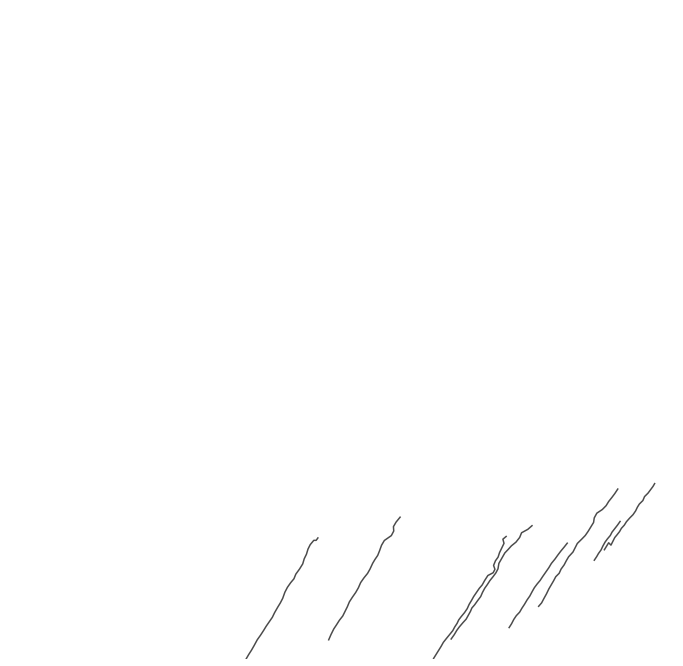

In [14]:
msds = 'msd_{}.csv'.format(filename)
feat = 'features_{}.csv'.format(filename)
hm.plot_trajectories(filename, resolution=dshape[0], rows=division_rows, cols=division_cols, upload=False, figsize=(12, 12), bucket = 'mckenna.data')
print('Successfully generated trajectory plot for {}'.format(filename))

Successfully generated csv files for Dextran-Red-2micron-confocal----10x


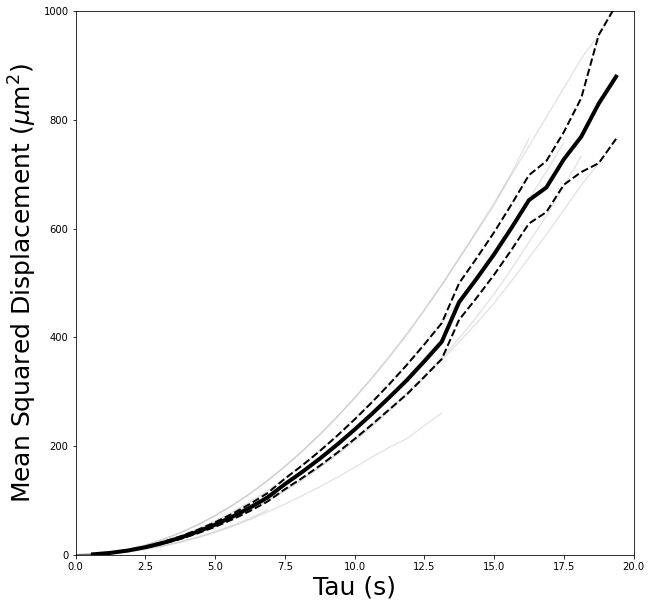

In [15]:
geomean, geoSEM = hm.plot_individual_msds(filename, x_range=20, y_range=1000, umppx=0.125, fps=fps, upload=False, bucket='mckenna.data')
print('Successfully generated csv files for {}'.format(filename))

# Plot Feature Heatmap

In [ ]:
#org_feat = 'orig_features_{}.csv'.format(filename)
#hm.plot_heatmap(org_feat, resolution=512, rows=division_rows, cols=division_cols, upload=False, figsize=(12, 12), bucket = 'mckenna.data')

feat = 'features_{}.csv'.format(filename)
hm.plot_heatmap(feat, resolution=512, rows=division_rows, cols=division_cols, upload=False, figsize=(12, 12), bucket = 'mckenna.data')

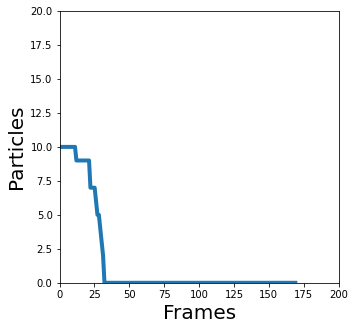

In [18]:
hm.plot_particles_in_frame(filename, x_range = 200, y_range = 20, upload=False, bucket = 'mckenna.data')

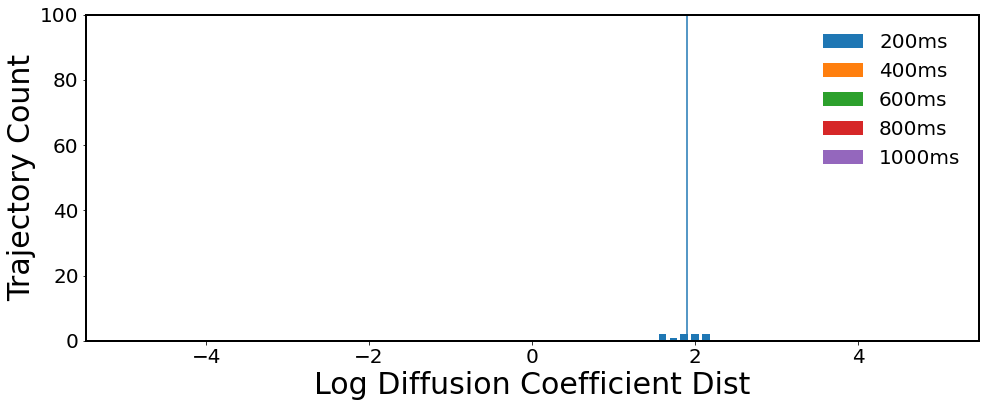

In [21]:
hm.plot_histogram(filename, xlabel='Log Diffusion Coefficient Dist', ylabel='Trajectory Count',
                   fps=fps, umppx=0.125, frames=32, y_range=100, frame_interval=20, frame_range=100,
                   analysis='log', theta='D', upload=False, remote_folder = "01_18_Experiment",
                    bucket = 'mckenna.data')